In [12]:
#import the libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [13]:
#Store the data into the df variable
df = pd.read_csv('../../data/ETH.csv')

In [14]:
#Set the date as the index for the data
df = df.set_index(pd.DatetimeIndex(df['begins_at'].values))
df['price'] = df[['high_price','low_price']].mean(axis=1)
#Show the dataframe
# df

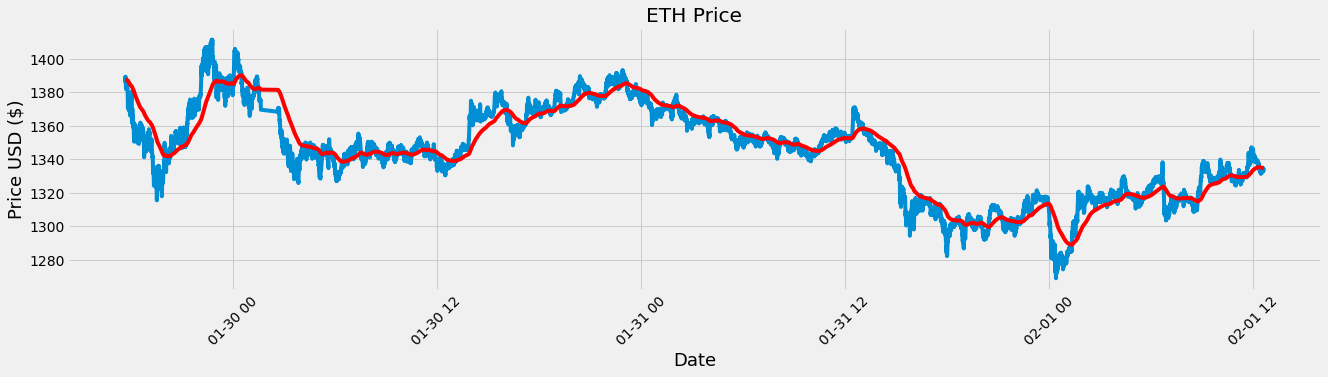

In [15]:
# Visually Show The Stock Price(s)
# Create the title
title = 'ETH Price'
#Get the stocks
my_stocks = df
#Create and plot the graph
plt.figure(figsize=(20,4.5)) #width = 12.2in, height = 4.5
plt.plot( my_stocks['price'],  label='price')#plt.plot( X-Axis , Y-Axis, line_width, alpha_for_blending,  label)

just_ema = df.price.ewm(span=400, adjust=False).mean()
plt.plot(df.index, just_ema, label='Exponential moving average', color = 'red')

plt.xticks(rotation=45) 
plt.title(title)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price USD ($)',fontsize=18)
plt.show()

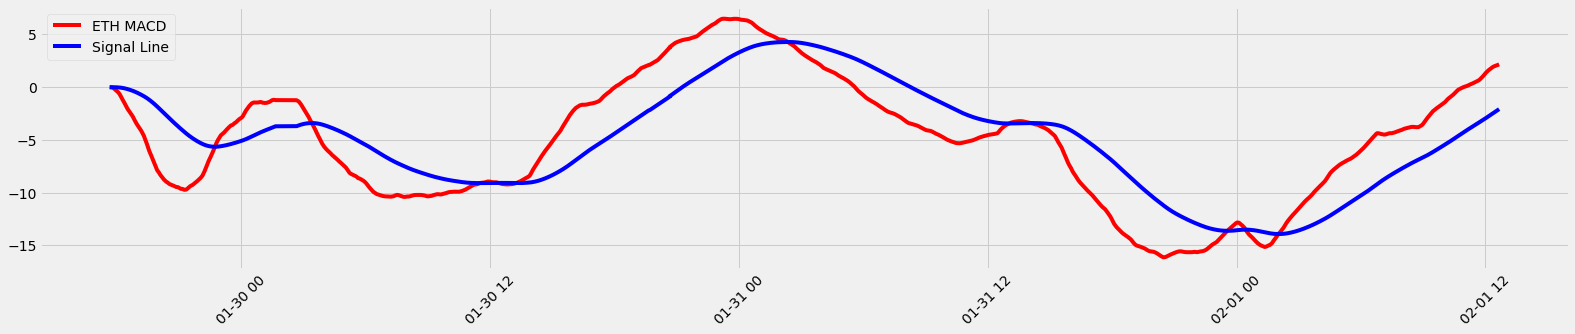

In [16]:

def createMacdAndSignalLines(macd_params, macd_multiplier):
    ShortEMA = df.price.ewm(span=macd_params[0]*macd_multiplier, adjust=False).mean() #AKA Fast moving average
    LongEMA = df.price.ewm(span=macd_params[1]*macd_multiplier, adjust=False).mean() #AKA Slow moving average
    Macd = ShortEMA - LongEMA
    signal = Macd.ewm(span=macd_params[2]*macd_multiplier, adjust=False).mean()
    return (Macd, signal)

macd_params = (12, 26, 9)
macd_multiplier = 175
macd, signal = createMacdAndSignalLines(macd_params, macd_multiplier)

plt.figure(figsize=(12.2*2,4.5)) #width = 12.2in, height = 4.5
plt.plot(df.index, macd, label='ETH MACD', color = 'red')
plt.plot(df.index, signal, label='Signal Line', color='blue')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()

In [17]:
df['MACD'] = macd
df['Signal Line'] = signal

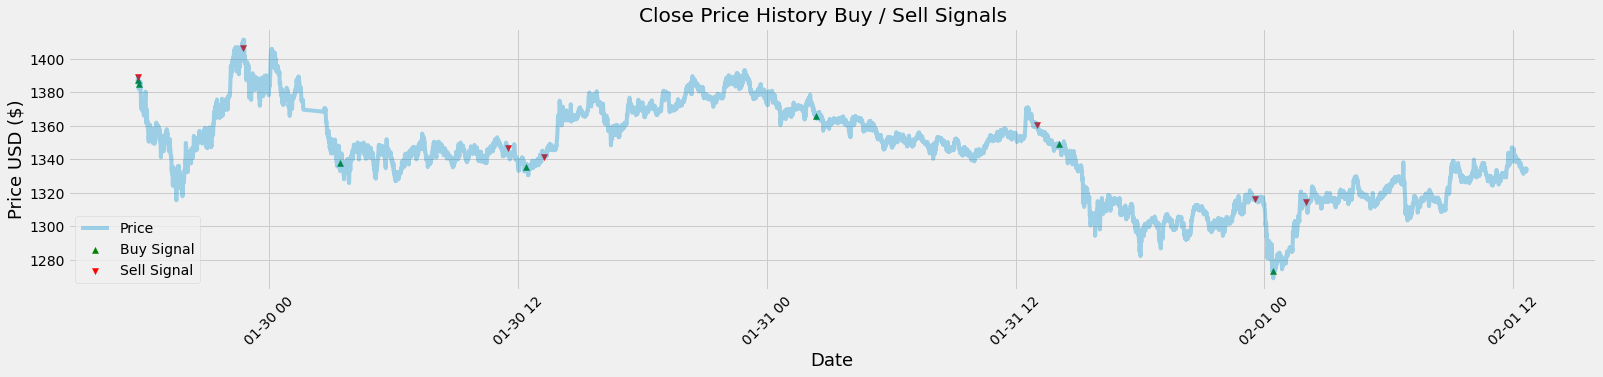

2021-01-29T17:41:15Z Bought at 1386.895  selling at 1389.93 for profit: 1.0350000000000819
2021-01-29T22:44:45Z Bought at 1379.72  selling at 1407.424423 for profit: 25.704422999999906
2021-01-30T11:30:15Z Bought at 1332.87  selling at 1350.925 for profit: 16.055000000000064
2021-01-30T13:14:30Z Bought at 1331.49  selling at 1342.155 for profit: 8.664999999999964
2021-01-31T13:01:45Z Bought at 1362.805  selling at 1364.07 for profit: -0.7350000000001273
2021-01-31T23:33:45Z Bought at 1345.19  selling at 1312.515 for profit: -34.674999999999955
2021-02-01T02:01:00Z Bought at 1276.225  selling at 1314.16 for profit: 35.93500000000017
Profit 51.984423000000106
trans:  7


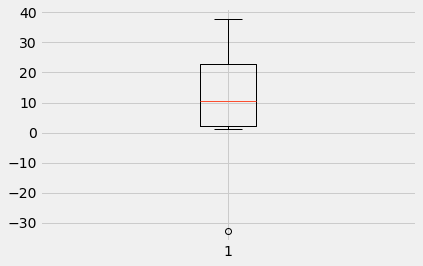

In [18]:
# Function to test the crossover driven profits of the macd and signal lines
def mac_daddy_tester(macd, signal, df, quiet=False):
    bought = False
    sumwin = 0
    transactions = []
    for i in range(1, len(signal)):
        if ( (macd.iat[i] < signal.iat[i]) and (macd.iat[i-1] >= signal.iat[i-1]) and bought == False):
            # print("Crossed above, time to buy", i)
            bought = df.iat[i,1]
        elif ( (macd.iat[i] > signal.iat[i]) and (macd.iat[i-1] <= signal.iat[i-1]) and bought):
            # print("Crossed below, time to sell", i)
            if not quiet:
              print(df.iat[i,0], "Bought at", bought, " selling at", df.iat[i,1], "for profit:", df.iat[i,1] - bought - 2)
            transactions.append(df.iat[i,1] - bought)
            sumwin = sumwin + df.iat[i,1] - bought - 2
            bought = False 
    return(sumwin, transactions)


#Create a function to signal when to buy and sell an asset
def buy_sell(signal):
  sigPriceBuy = []
  sigPriceSell = []
  flag = -1
  for i in range(0,len(signal)):
    #if MACD > signal line  then buy else sell
      if signal['MACD'][i] < signal['Signal Line'][i]:
        if flag != 1:
          sigPriceBuy.append(signal['price'][i])
          sigPriceSell.append(np.nan)
          flag = 1
        else:
          sigPriceBuy.append(np.nan)
          sigPriceSell.append(np.nan)
      elif signal['MACD'][i] > signal['Signal Line'][i]: 
        if flag != 0:
          sigPriceSell.append(signal['price'][i])
          sigPriceBuy.append(np.nan)
          flag = 0
        else:
          sigPriceBuy.append(np.nan)
          sigPriceSell.append(np.nan)
      else: #Handling nan values
        sigPriceBuy.append(np.nan)
        sigPriceSell.append(np.nan)
  
  return (sigPriceBuy, sigPriceSell)


#Create buy and sell columns
x = buy_sell(df)
df['Buy_Signal_Price'] = x[0]
df['Sell_Signal_Price'] = x[1]

# Visually Show The Stock buy and sell signals
# Create the title 
title = 'Close Price History Buy / Sell Signals   '
#Get the stocks
my_stocks = df
  
#Create and plot the graph
plt.figure(figsize=(12.2*2,4.5)) #width = 12.2in, height = 4.5
plt.scatter(my_stocks.index, my_stocks['Buy_Signal_Price'], color = 'green', label='Buy Signal', marker = '^', alpha = 1)
plt.scatter(my_stocks.index, my_stocks['Sell_Signal_Price'], color = 'red', label='Sell Signal', marker = 'v', alpha = 1)
plt.plot( my_stocks['price'],  label='Price', alpha = 0.35, linewidth=1)#plt.plot( X-Axis , Y-Axis, line_width, alpha_for_blending,  label)
plt.xticks(rotation=45)
plt.title(title)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price USD ($)',fontsize=18)
plt.legend( loc='lower left')
plt.show()

r = mac_daddy_tester(macd, signal, df)
print("Profit", r[0])
print("trans: ", len(r[1]))
plt.boxplot(r[1])
plt.show()
# print(r[1])

In [19]:
run_cell = True
if run_cell:
    results = []
    for period_length in np.arange(2, 700, 2):
        macd_params = (12, 26, 9)
        macd_multiplier = period_length #was 111
        macd, signal = createMacdAndSignalLines(macd_params, macd_multiplier)
        r = mac_daddy_tester(macd, signal, df, quiet=True)
        results.append((period_length, r[0], len(r[1])))
        # print(period_length, "Profit", r[0], "transactions: ", len(r[1]))
    print(sorted(results, key = lambda x: -x[1]))

In [20]:
    sorted(results, key = lambda x: -x[1])

[(170, 44.510245000000396, 7),
 (172, 44.40799600000014, 7),
 (174, 41.49715200000014, 7),
 (152, 40.55655700000011, 6),
 (166, 38.24749799999995, 6),
 (176, 37.18190299999992, 7),
 (46, 36.36999999999989, 18),
 (160, 35.25593300000037, 6),
 (178, 35.015363000000434, 7),
 (162, 31.35740900000019, 6),
 (38, 28.77999999999929, 23),
 (36, 25.21499999999969, 24),
 (150, 25.204227000000174, 6),
 (164, 25.029466000000184, 6),
 (180, 24.814910000000282, 7),
 (168, 22.816483000000062, 7),
 (182, 20.950635000000148, 6),
 (138, 16.98767900000007, 6),
 (48, 16.63500000000022, 16),
 (132, 16.17179199999987, 6),
 (142, 15.166686000000254, 6),
 (144, 15.143504000000348, 6),
 (286, 14.365000000000009, 4),
 (272, 13.995000000000118, 4),
 (78, 13.75, 9),
 (130, 13.315000000000055, 6),
 (148, 12.590000000000146, 6),
 (56, 11.94000000000051, 18),
 (694, 11.100000000000136, 2),
 (184, 10.87713900000017, 5),
 (156, 10.869458000000122, 6),
 (136, 10.393403000000035, 6),
 (288, 10.010000000000218, 4),
 (134,